In [1]:
import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment', None)
import geopandas as gpd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
from matplotlib.dates import DateFormatter
from datetime import datetime as dt
import statsmodels.api as sm
from scipy import stats

In [2]:
root = './'
auxdata = root+"auxdata/"

In [3]:
strin = pd.read_csv(auxdata+"stringency_fourstates_monthly.csv")
strin['month'] = pd.to_datetime(strin['month'])

In [4]:
df = pd.read_csv(root+"fig1/"+"fig1C.csv")    

In [5]:
def getdatforplot_trends(df, city_name, diff):
    this = df[(df['city']==city_name)&(df['variable']=="uid_indivseg")]
    useg_both = pd.DataFrame({'date':this['date'], 'excessseg':this['value']})
    useg_both['yyyymm_d'] = pd.to_datetime(useg_both['date'])
    useg_both = useg_both[useg_both["yyyymm_d"]>dt.strptime("2020-03-01","%Y-%m-%d")]
    return useg_both

def get_datatable(df,city,state):
    this = getdatforplot_trends(df, city, '2019')
    this_strin = strin[strin['RegionName']==state][['month','StringencyIndex']]
    this_strin['yyyymm_d'] = pd.to_datetime(this_strin['month'])
    this = this[['yyyymm_d','excessseg',]].merge(this_strin, on='yyyymm_d', how='left')
    return this

def run_regression(this):
    YX = this[['excessseg','StringencyIndex']].dropna()
    Y = YX[['excessseg']]
    X = YX.drop(columns='excessseg')
    X = sm.add_constant(X)
    results = sm.OLS(Y,X).fit()
    return results, Y, X

In [6]:
def colordate(date):
    if date==dt.strptime('2020-04-01', '%Y-%m-%d'):
        return 'red'
    elif date==dt.strptime('2020-05-01', '%Y-%m-%d'):
        return 'red'
    elif (date==dt.strptime('2020-12-01', '%Y-%m-%d'))|(date==dt.strptime('2021-01-01', '%Y-%m-%d')):
        return 'orange'
    else:
        return 'gray'
    
def markerdate(date):
    if date==dt.strptime('2020-04-01', '%Y-%m-%d'):
        return 's'
    elif date==dt.strptime('2020-05-01', '%Y-%m-%d'):
        return 's'
    elif (date==dt.strptime('2020-12-01', '%Y-%m-%d'))|(date==dt.strptime('2021-01-01', '%Y-%m-%d')):
        return '^'
    else:
        return 'o'

C:\Users\yabec\anaconda3\envs\py38\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


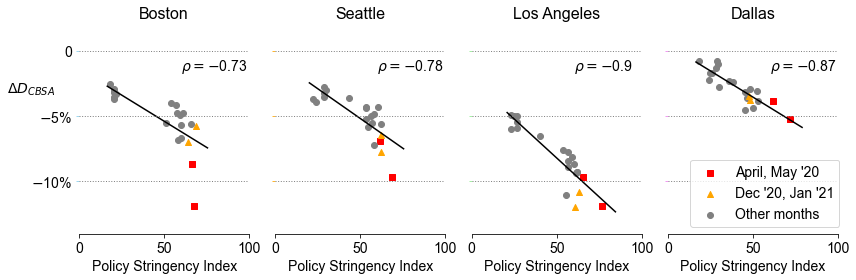

In [7]:
fig,ax = plt.subplots(1,4,figsize=(12,4), sharey=True)
fig.patch.set_facecolor('white')
for i,(city,nam,col,state,xticks,yticks) in enumerate(zip(['boston','seattle','la','dallas'],
                                                          ['Boston','Seattle','Los Angeles','Dallas'],
                                                          ['skyblue','orange','lightgreen','violet'],
                                                          ['Massachusetts','Washington','California','Texas'],
                                                          [[0,50,100],[0,50,100],[0,50,100],[0,50,100]],
                                                          [[-10,-5,0],[-10,-5,0],[-10,-5,0],[-10,-5,0]])):
    axthis = ax[i]
    this = get_datatable(df,city,state)
    this['color'] = this['yyyymm_d'].apply(lambda x: colordate(x))
    this['marker'] = this['yyyymm_d'].apply(lambda x: markerdate(x))
    res,y,x = run_regression(this)
    const = res.params["const"]
    for ind,row in this.iterrows():
        axthis.scatter(row["StringencyIndex"], y.values[ind], color=row['color'], marker=row['marker'])
        
    if i==3:
        axthis.scatter([],[],color='red', label="April, May '20", marker='s')
        axthis.scatter([],[],color='orange', label="Dec '20, Jan '21", marker='^')
        axthis.scatter([],[],color='gray', label='Other months', marker='o')
        axthis.legend(loc="lower right", bbox_to_anchor=(1.05,0), fontsize=14)        
        
    slope, intercept, r_value, p_value, std_err = stats.linregress(this["StringencyIndex"].values.flatten(),y.values.flatten())
    axthis.annotate(r"$\rho=$"+str(round(r_value,2)).replace("-",r"$\minus$"), xy=(.6,.78), xycoords='axes fraction', fontsize=14)
      
    axthis.plot([min(this["StringencyIndex"])*0.9,max(this["StringencyIndex"])*1.1], 
                [intercept+min(this["StringencyIndex"])*0.9*slope, intercept+max(this["StringencyIndex"])*1.1*slope], color='k')
    axthis.spines['top'].set_visible(False)
    axthis.spines['left'].set_visible(False)
    axthis.spines['right'].set_visible(False)
    axthis.set_xticks(xticks)
    axthis.set_xticklabels(xticks, fontsize=14)
    axthis.set_yticks(yticks)
    axthis.set_ylim(-14,2)

    if i == 0:
        newyticks = []
        for ytick in yticks:
            if ytick<0:
                newyticks.append(r"$\minus$"+str(ytick).replace("-","")+"%")
            else:
                newyticks.append(str(ytick))
        axthis.set_yticklabels(newyticks, fontsize=14)
        axthis.set_ylabel(r"$\Delta D_{CBSA}$", fontsize=14, rotation=0, y=.65, labelpad=0)
        
    axthis.set_xlabel("Policy Stringency Index", fontsize=14)#\n["+str(-res.params["StringencyIndex"])[:5]+"*$SI_{CBSA}$"+"]", fontsize=14)
    axthis.set_title(nam, fontsize=16)
    axthis.tick_params(axis=u'y', which=u'both',color=col)
    
    for ytick in yticks:
        axthis.axhline(ytick, linestyle=":", linewidth=1, color='gray')

plt.tight_layout()
# plt.savefig(outpath+"covid_seg_death_onlystringency_colored.png",dpi=200, bbox_inches='tight')
plt.show()    